In [1]:
import torch
from torch.utils.data import Dataset
from PIL import Image, ImageDraw, ImageFont
import json
import os
import numpy as np
from utils.im_utils import Compose, ToTensor, RandomHorizontalFlip

In [2]:
with open('/opt/ml/dataset_for_yolo/train.json') as f:
    json_data = json.load(f)
print(json_data.keys())
print(json_data['info'])
print(len(json_data['annotations']))
print(json_data['annotations'][1])
print(json_data['images'][1])

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])
{'year': 2021, 'version': '1.0', 'description': 'Recycle Trash', 'contributor': 'Upstage', 'url': None, 'date_created': '2021-02-02 01:10:00'}
23144
{'image_id': 1, 'category_id': 3, 'area': 10402.56, 'bbox': [0.0, 407.4, 57.6, 180.6], 'iscrowd': 0, 'id': 1}
{'width': 1024, 'height': 1024, 'file_name': 'train/0001.jpg', 'license': 0, 'flickr_url': None, 'coco_url': None, 'date_captured': '2021-01-10 16:30:39', 'id': 1}


In [3]:
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import json
from PIL import Image
from collections import defaultdict

def get_json_data(root_dir):
    """_summary_
    json 파일에서 데이터를 읽어오는 함수

    Args:
        root_dir (str): json 파일이 들어 있는 폴더

    Returns:
        json_data (dict): json data가 들어 있는 dictionary
    """
    json_path = os.path.join(root_dir, 'train.json')

    with open(json_path) as f:
        json_data = json.load(f)
    
    return json_data


def get_all_annotation(json_data):
    """_summary_
    json_data에서 annotation 정보들을 dict(list)로 추출

    Args:
        json_data (dict): json_data

    Returns:
        annotation (dict): key = img id, value = annotation 정보가 들어있는 list
    """
    anno = defaultdict(list)
    for i in json_data['annotations']:
        anno[str(i['image_id'])].append(i)
    
    return anno


def split_train_valid(root_dir, json_data, val_ratio=0.2):
    """_summary_

    Args:
        root_dir (str): data가 들어있는 폴더 path
        json_data (dict): json data가 들어잇는 data
        val_ratio (float, optional): train, valid set을 나누는 비율. Defaults to 0.2.

    Returns:
        train, val path_info (list): [id, image_paths]의 데이터를 train과 validation info를 return
    """
    
    image_info = np.array([[i['id'], os.path.join(root_dir,i['file_name']) ] for i in json_data['images']])
    # validation set legnth
    length = int(len(image_info))
    split_length = int(val_ratio * length)

    # shuffle
    idx = np.random.permutation(image_info.shape[0])
    image_info = image_info[idx]
    
    # split info
    train_info = image_info[:length-split_length]
    val_info = image_info[length-split_length:]
    return train_info, val_info


class CustomDataset(Dataset):
    classes = ['General trash', 
               'Paper', 
               'Paper pack', 
               'Metal', 'Glass', 
               'Plastic', 
               'Styrofoam', 
               'Plastic bag', 
               'Battery', 
               'Clothing']
    
    classes_id = [i for i in range(len(classes))]

    def __init__(self, image_info, json_anno, transforms=None):
        self._transforms = transforms
        
        self.num_classes = len(self.classes)
        self.image_ids = image_info[:,0]
        self.image_paths = image_info[:,1]
        self.all_annotation = json_anno
        self.width = 1024
        self.height = 1024

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self,idx):
        img_path = self.image_paths[idx]
        print(img_path)
        img = Image.open(img_path)
        
        id = self.image_ids[idx]
        print(id,type(id))
        w = self.width
        h = self.height
        objs = []
        print(self.all_annotation[id])
        for obj in self.all_annotation[id]:
            x1 = np.max((0, obj['bbox'][0]))
            y1 = np.max((0, obj['bbox'][1]))
            x2 = np.min((w - 1, x1 + np.max((0, obj['bbox'][2] - 1))))
            y2 = np.min((h - 1, y1 + np.max((0, obj['bbox'][3] - 1))))
            if obj['area'] > 0 and x2 > x1 and y2 > y1:
                obj['clean_bbox'] = [x1, y1, x2, y2]
                objs.append(obj)
        
        num_objs = len(objs)

        boxes = np.zeros((num_objs, 4), dtype=np.float32)
        gt_classes = np.zeros((num_objs), dtype=np.int32)

        iscrowd = []
        for ix, obj in enumerate(objs):
            boxes[ix,:] = obj['clean_bbox']
            gt_classes[ix] = obj['category_id']
            iscrowd.append(int(obj['iscrowd']))

        image_id = torch.tensor([idx])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        gt_classes = torch.as_tensor(gt_classes, dtype=torch.int32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int32)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {"boxes": boxes, "labels": gt_classes, "image_id": image_id, "area": area, "iscrowd": iscrowd}

        if self._transforms is not None:
            img, target = self._transforms(img, target)
        
        return img, target

    @staticmethod
    def collate_fn(batch):
        return tuple(zip(*batch))

In [4]:
data_root_dir = '/opt/ml/dataset'
json_data = get_json_data(data_root_dir)
    
json_anno = get_all_annotation(json_data)
print(json_anno[1])
for i in json_anno[1]:
    print(i)
train_info, val_info = split_train_valid(data_root_dir, json_data)


# data_transform = {
#         "train": Compose([ToTensor(), RandomHorizontalFlip(0.5)]),
#         "val": Compose([ToTensor()])
#     }


dataset = CustomDataset(train_info, json_anno)


[]


In [5]:
img,d = dataset.__getitem__(1)
d

/opt/ml/dataset/train/0568.jpg
568 <class 'numpy.str_'>
[{'image_id': 568, 'category_id': 7, 'area': 350186.2, 'bbox': [262.3, 218.4, 542.0, 646.1], 'iscrowd': 0, 'id': 2668}]


{'boxes': tensor([[262.3000, 218.4000, 803.3000, 863.5000]]),
 'labels': tensor([7], dtype=torch.int32),
 'image_id': tensor([1]),
 'area': tensor([348999.0938]),
 'iscrowd': tensor([0], dtype=torch.int32)}

In [6]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']


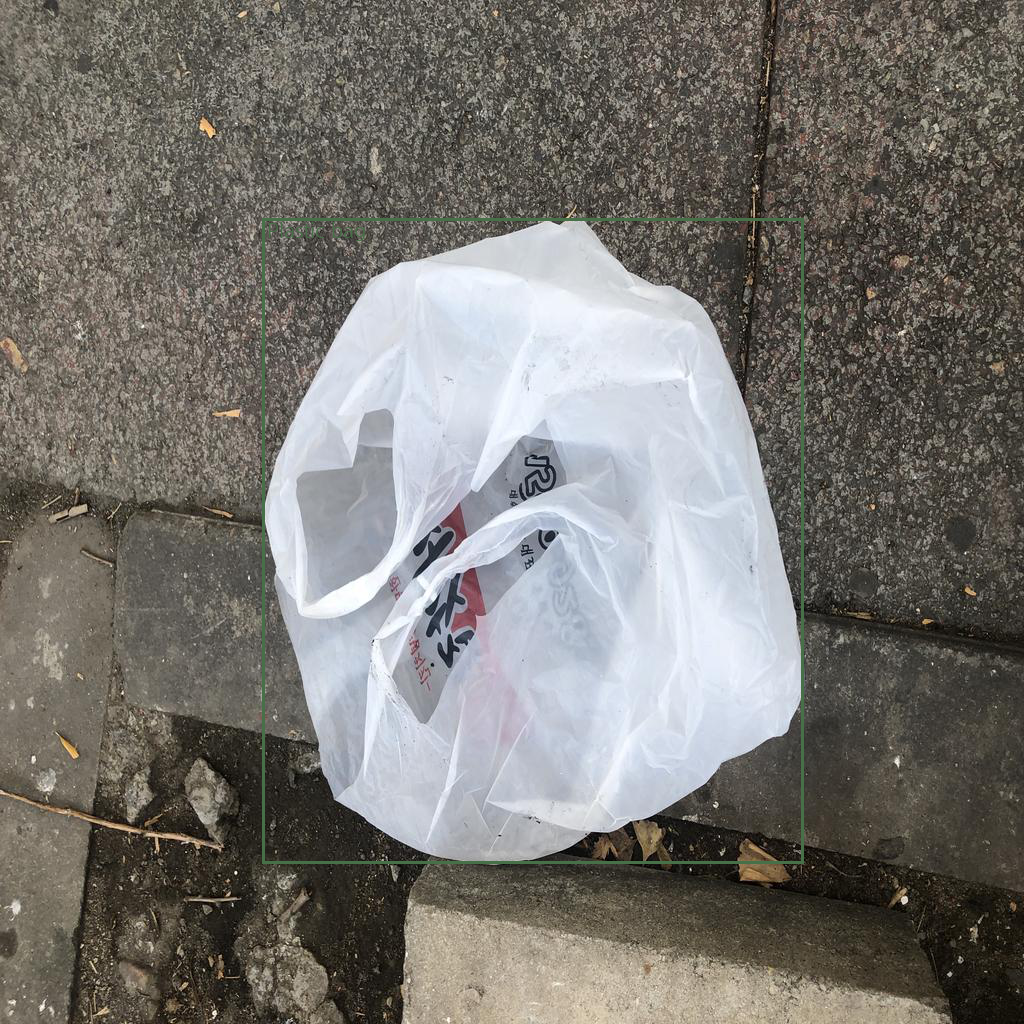

In [7]:
import random
# img = img.permute(1,2,0).numpy()
boxes = d['boxes'].numpy()
labels = d['labels'].numpy()
classes = dataset.classes
print(classes)
colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(len(classes))]
draw = ImageDraw.Draw(img)
for i in range(len(boxes)):
    box = boxes[i]
    label = labels[i]
    color = colors[label]
    font = ImageFont.truetype('/usr/share/fonts/truetype/nanum/NanumGothic.ttf',20)
    draw.rectangle(box, outline=color, width=3)
    draw.text((box[0]+5,box[1]),  classes[label], font=font, fill=color)
img.show()